# Project
- Exploratory data analysis 
- Data Pre-processing
- Feature Selection
- Model Training and Development
- Model Evaluation


In [16]:
# import basic packages for data analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.model_selection import train_test_split
import math
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm 

Please do download northern Brazil weather data from kaggle via this link (https://www.kaggle.com/datasets/PROPPG-PPG/hourly-weather-surface-brazil-southeast-region) and attach it to the same folder as this IPYNB file. The file that should be downloaded from the webpage is called north.csv, and you would be able to find it under the data explorer section of the Kaggle webpage for this dataset.

In [2]:
# Load data
df = pd.read_csv("./north.csv")

In [3]:
# Check first 5 rows
print(df.head())

# Get the shape of data
print(df.shape)

# Get the columns of the data
print(df.columns)

   index        Data   Hora  PRECIPITAÇÃO TOTAL, HORÁRIO (mm)  \
0      0  2000-05-09  00:00                           -9999.0   
1      1  2000-05-09  01:00                           -9999.0   
2      2  2000-05-09  02:00                           -9999.0   
3      3  2000-05-09  03:00                           -9999.0   
4      4  2000-05-09  04:00                           -9999.0   

   PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)  \
0                                            -9999.0       
1                                            -9999.0       
2                                            -9999.0       
3                                            -9999.0       
4                                            -9999.0       

   PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)  \
0                                          -9999.0   
1                                          -9999.0   
2                                          -9999.0   
3                               

Given that the column names are in Portugese, it would be ideal to change these names to English for ease of understanding. In addition, there are many -9999 values evident in the first 10 printed rows of the data, which might be indicative of NaN values, which we would be dealing with later on.

In [4]:
# Change column headers to shortened english labels
column_name_english = ['idx', 'date','hour','tPrec','atmosPStatn','prevHrPmax','prevHrPmin','rad','airTemp','dpTemp','prevHrMaxTemp','prevHrMinTemp','prevHrMaxDpTemp','prevHrMinDpTemp','prevHrMaxHum','prevHrMinHum','airHum','windDir','maxWindSp','windSp','reg','state','statn','statnCode','lat','long','height']
df.columns = column_name_english

There are object types present in the dataset on top of int and floats. We would need to convert these types to numeric types in order to perform a regression analysis that predicts the temperature.

In [5]:
# Get detailed info of dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8392320 entries, 0 to 8392319
Data columns (total 27 columns):
 #   Column           Dtype  
---  ------           -----  
 0   idx              int64  
 1   date             object 
 2   hour             object 
 3   tPrec            float64
 4   atmosPStatn      float64
 5   prevHrPmax       float64
 6   prevHrPmin       float64
 7   rad              int64  
 8   airTemp          float64
 9   dpTemp           float64
 10  prevHrMaxTemp    float64
 11  prevHrMinTemp    float64
 12  prevHrMaxDpTemp  float64
 13  prevHrMinDpTemp  float64
 14  prevHrMaxHum     int64  
 15  prevHrMinHum     int64  
 16  airHum           int64  
 17  windDir          int64  
 18  maxWindSp        float64
 19  windSp           float64
 20  reg              object 
 21  state            object 
 22  statn            object 
 23  statnCode        object 
 24  lat              float64
 25  long             float64
 26  height           float64
dtypes: float64(1

In [6]:
# Drop irrelavent columns 
df.drop(['idx'],inplace=True, axis=1)

# Replace all nan values and delete rows with nan values
df = df.replace(to_replace=-9999,value=np.NaN)
# Check for existence of nan values
print(df.isnull().sum())
# Drop all nans
df.dropna(inplace=True)

date                     0
hour                     0
tPrec              1988221
atmosPStatn        1591222
prevHrPmax         1597892
prevHrPmin         1597871
rad                4540804
airTemp            1551208
dpTemp             1706311
prevHrMaxTemp      1558370
prevHrMinTemp      1558241
prevHrMaxDpTemp    1713899
prevHrMinDpTemp    1715709
prevHrMaxHum       1707478
prevHrMinHum       1711836
airHum             1706495
windDir            1847536
maxWindSp          1810415
windSp             1797836
reg                      0
state                    0
statn                    0
statnCode                0
lat                      0
long                     0
height              273960
dtype: int64


From the below code, we infer that the station code uniquely identifies the station name, given that their numbers are approximately equal. However, for a particular station code, there may be multiple heights, latitudes of longitudes. For this reason, we have decided that variables such as altitude, longitude and height will be sufficient to uniquely identify a particular location, while station code, station name and region can be omitted in our analysis. 

In [7]:
# Shows one station can have multiple height variables
df_statnCode_A101 = df[df['statnCode'] == 'A101']
print(df_statnCode_A101['height'].value_counts())

# Remove non-important columns
df.drop(['statnCode', 'reg', 'state', 'statn' ],inplace=True, axis=1)


61.25    65272
48.79    19392
Name: height, dtype: int64


In order to change the date and time to a numerical value, we concatenate the date and time, then covert it to an ordinal value, which is a numerical representation for the date and time. This will be helpful as the traning data are formatted to only include numerical types, which is ideal for model training later on.

In [8]:
df['date_time'] = pd.to_datetime(df['date'] + ' ' +  df['hour'])
df.drop(['date', 'hour' ],inplace=True, axis=1)
df['date_time']=df['date_time'].map(dt.datetime.toordinal)

We can attempt to visualize the distribution of the response variable, airTemp, using a histogram and a boxplot as shown below. We can see that a significant proportion of the temperatures lie between 25 degrees and 32 degrees. However, we also realize that there is some data 17 degrees and below that fall outside the 1.5 x IQR range.

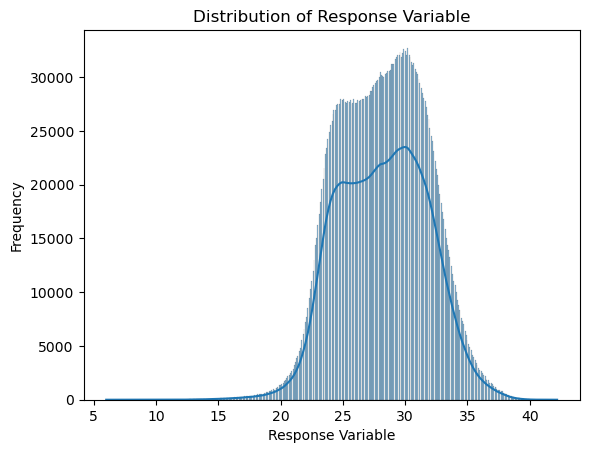

<AxesSubplot:ylabel='airTemp'>

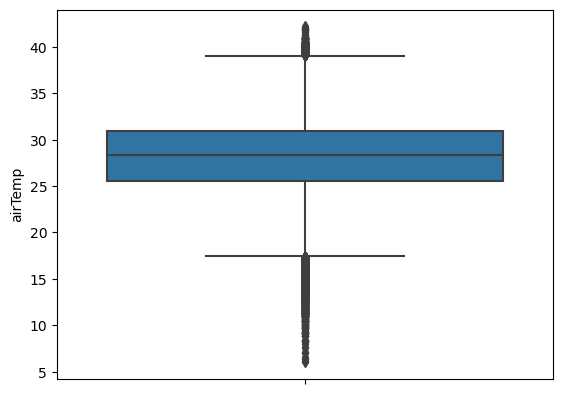

In [14]:
# Visualize the distribution of the response variable (airTemp)
sns.histplot(df['airTemp'], kde=True)
plt.title('Distribution of Response Variable')
plt.xlabel('Response Variable')
plt.ylabel('Frequency')
plt.show()

sns.boxplot(y = df['airTemp'])

We then find the correlation matrix and split up the heatmap plots to be able to obtain a better visual representation of the correlations

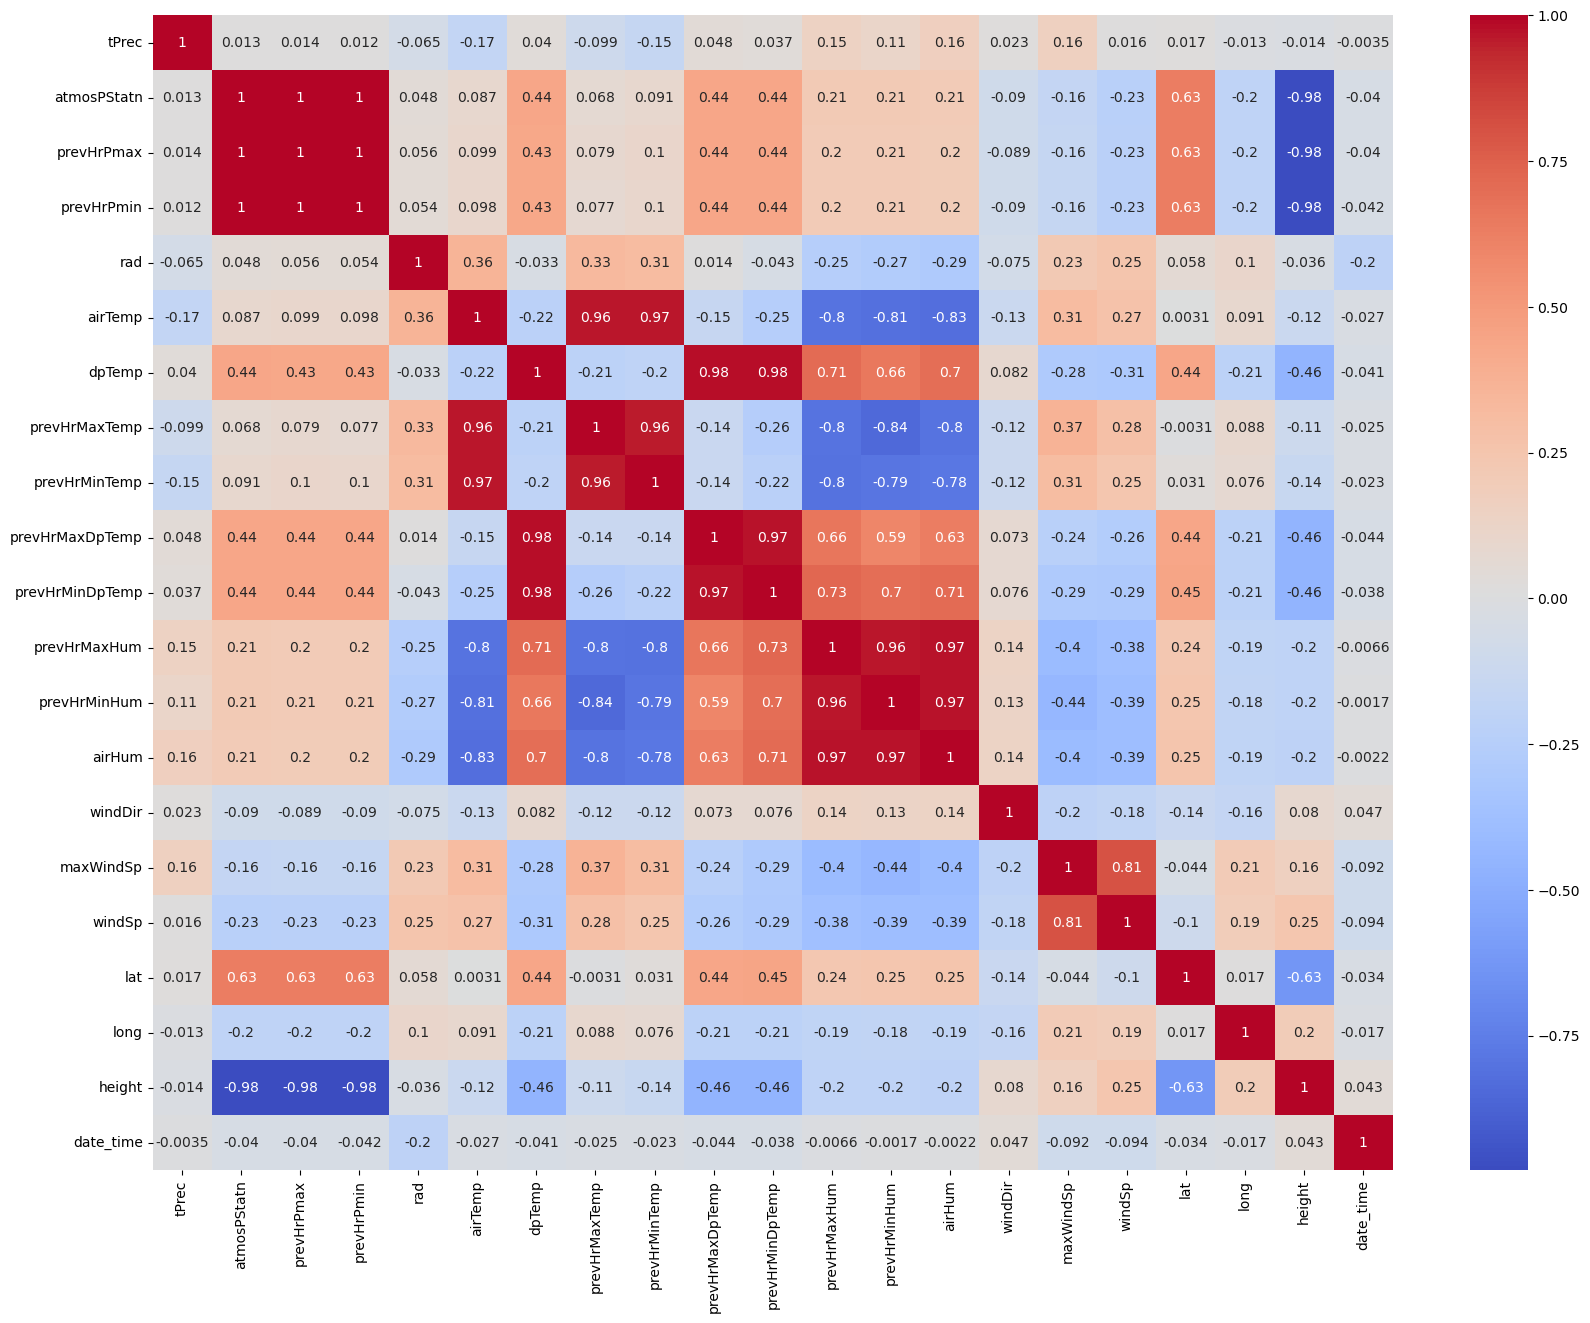

In [39]:
## get the correlation matrix of the data
corr_matrix = df.corr()
plt.subplots(figsize=(20,15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

For the code below, we plot a scatter plot for the top 9 variables that are correlated with airTemp. We can see that especially for the first two graphs, which are prevHrMinTemp and prevHrMaxTemp respectively, we can see a relatively linear relationship between these variables and airTemp. However for the rest of the graphs, the relationship with airtemp generally becomes less clear.

airTemp            1.000000
prevHrMinTemp      0.966455
prevHrMaxTemp      0.963276
airHum             0.825103
prevHrMinHum       0.810764
prevHrMaxHum       0.800382
rad                0.359995
maxWindSp          0.313604
windSp             0.267056
prevHrMinDpTemp    0.249279
dpTemp             0.216788
tPrec              0.171465
prevHrMaxDpTemp    0.146825
windDir            0.127466
height             0.122126
prevHrPmax         0.099273
prevHrPmin         0.097684
long               0.090917
atmosPStatn        0.087221
date_time          0.027103
lat                0.003129
Name: airTemp, dtype: float64
['prevHrMinTemp', 'prevHrMaxTemp', 'airHum', 'prevHrMinHum', 'prevHrMaxHum', 'rad', 'maxWindSp', 'windSp', 'prevHrMinDpTemp']


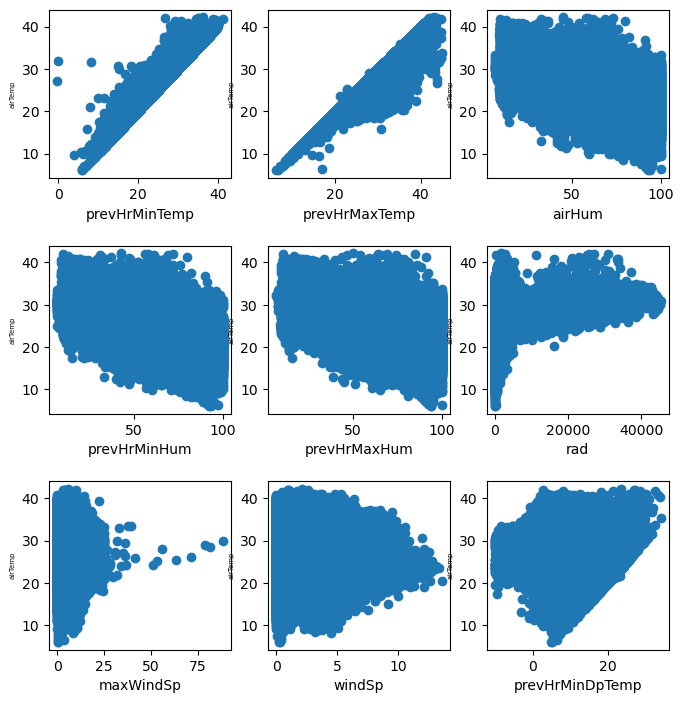

In [46]:
y_temp = df['airTemp']

# Find out the variables that are most correlated with airTemp
most_corr_df = corr_matrix['airTemp'].abs().sort_values(ascending=False)
print(most_corr_df)

# Get a list of top 10 most correlated variables
most_corr_var = list(most_corr_df.index.values)[:10]
most_corr_var.pop(0)
print(most_corr_var)

# create a figure and an axes object with a specific size for plotting
fig, ax = plt.subplots(3, 3, figsize=(8,8))
for j in range(len(most_corr_var)):
    row_idx = math.floor(j/3)
    col_idx = j % 3
    ax[row_idx, col_idx].scatter(df[most_corr_var[j]], y_temp)
    ax[row_idx, col_idx].set_xlabel(most_corr_var[j], fontsize=10) # set label for x axis
    ax[row_idx, col_idx].set_ylabel('airTemp', fontsize=5) # set label for y axis
plt.subplots_adjust(left=0.125, right=0.9, bottom=0.1, top=0.9, hspace=0.4)
plt.show()


We see that atmosPstatn, the atmnospheric pressure at the station level is very highly correlated with prevHrPmin and prevHrPmax, as it is likely that any increases in the prevHrPmin or prevHrPmin would result in corresponding changes in the atmospheric pressure. Thus, we can proceed to omit prevHrPmin and prevHrPmax from our dataframe. Some other examples of high correlation is dewpoint temperature with prevHrMaxDpTemp and prevHrMinDpTemp, which is logical given that the min and max dewpoint temperature range in the previous would significantly influence the current dewpoint temperature, thus we can omit the prevHrMax and Min DpTemp from our dataframe. We will seek to drop variables that has a correlation value of more than 0.8 with another. After the drop operations, we are left with 11 predictor variables and 1 response variable.

In [9]:
# Removed as highly correlated with atmosPStatn
df.drop(['prevHrPmin', 'prevHrPmax'],inplace=True, axis=1)

# Removed as highly correlated with dpTemp
df.drop(['prevHrMaxDpTemp', 'prevHrMinDpTemp'],inplace=True, axis=1)

# Removed as highly correlated with prevHrMinTemp
df.drop(['prevHrMaxTemp'], inplace=True, axis=1)

# Removed as highly correlated with dpTemp
df.drop(['prevHrMaxHum', 'prevHrMinHum'],inplace=True, axis=1)

# Removed as highly correlated with windSp
df.drop(['maxWindSp'], inplace=True, axis=1)

# Removed as highly correlated with atmosPStatn
df.drop(['height'], inplace=True, axis=1)

In [10]:
def split_group(group):
    # Sort values in asecending ordinal date_time
    group = group.sort_values(by='date_time')
    # Non-random, ordered train-test split
    train_set, test_set = train_test_split(group, test_size=0.3, shuffle = False, stratify = None)
    return train_set, test_set

# Group by combination of latitude and longitude
group = df.groupby(['lat', 'long'])

# Apply the split_group function to each group
train_test_sets = group.apply(split_group)

# Construct the train and test set dataframes
train_set = pd.concat([x[0] for x in train_test_sets])
train_set.reset_index(drop=True, inplace=True)

test_set = pd.concat([x[1] for x in train_test_sets])
test_set.reset_index(drop=True, inplace=True)

X_train = train_set.drop(['airTemp'], axis=1)
y_train = train_set['airTemp']
X_test = test_set.drop(['airTemp'], axis=1)
y_test = test_set['airTemp']


### Model Selection For Simple Regression
To find the best model for this dataset, we compare the performance of simple regression and more complex regression models. We use three simple regression models to test the performance of the simpler model and then determine the best simpler regression model for this dataset.

Use forward and backward selection method to determine the best linear regression model.

In [17]:
def forward_selection(X_train, y_train, significance_level=0.05):
    # Start with no predictors
    initial_features = X_train.columns.tolist()
    best_features = []
    
    while len(initial_features) > 0:  # Iterate over the set of all features
        remaining_features = list(set(initial_features) - set(best_features))
        new_pval = pd.Series(index=remaining_features)
        
        for new_column in remaining_features: # Iterate over the remaining features not yet included
            # Fit model with the selected features and one additional feature
            model = sm.OLS(y_train, sm.add_constant(pd.DataFrame(X_train[best_features + [new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        
        min_p_value = new_pval.min()
        if min_p_value < significance_level: # If the p-value is below the significance level, add it to the best features
            best_features.append(new_pval.idxmin())
        else:
            break

    return best_features, len(best_features)

def backward_elimination(X_train, y_train, significance_level=0.05):
    # Start with all predictors
    features = X_train.columns.tolist()
    
    # Iterate as long as there are features to consider
    while len(features) > 0:
        features_with_constant = sm.add_constant(X_train[features])
        p_values = sm.OLS(y_train, features_with_constant).fit().pvalues[1:]
        max_p_value = p_values.max()
        
        # If the max p-value is above the significance level, remove that feature
        if max_p_value >= significance_level:
            excluded_feature = p_values.idxmax()
            features.remove(excluded_feature)
        else:
            break 
            
    return features, len(features)

In [18]:
# Forward selection
selected_features_forward, count_forward = forward_selection(X_train, y_train)
print("Selected features by forward selection:", selected_features_forward)
print("Number of features selected:", count_forward)

# Backward elimination
selected_features_backward, count_backward = backward_elimination(X_train, y_train)
print("Selected features by backward elimination:", selected_features_backward)
print("Number of features selected:", count_backward)

C:\Users\eddie\AppData\Local\Temp\ipykernel_13432\3788858045.py:8: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
C:\Users\eddie\AppData\Local\Temp\ipykernel_13432\3788858045.py:8: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
C:\Users\eddie\AppData\Local\Temp\ipykernel_13432\3788858045.py:8: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
C:\Users\eddie\AppData\Local\Temp\ipykernel_13432\3788858045.py:8: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future ve

Selected features by forward selection: ['rad', 'prevHrMinTemp', 'lat', 'long', 'dpTemp', 'airHum', 'atmosPStatn', 'windSp', 'tPrec', 'windDir']
Number of features selected: 10
Selected features by backward elimination: ['tPrec', 'atmosPStatn', 'rad', 'dpTemp', 'prevHrMinTemp', 'airHum', 'windDir', 'windSp', 'lat', 'long']
Number of features selected: 10


The forward and backward stepwise selection methods are returning 10 variables as significant, it suggests that each variable in our dataset might be contributing meaningfully to the prediction of air temperature.

In [19]:
X_train_1 = X_train.drop(['date_time'], inplace=False, axis=1)
X_test_1 = X_test.drop(['date_time'], inplace=False, axis=1)

In [20]:
# Function to train and evaluate a model
def train_and_evaluate(model, X_train, X_test, y_train, y_test):
    # Train the model
    model.fit(X_train, y_train)
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate performance 
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    return mse, mae, r2

In [21]:
# Function to find the optimal alpha level for ridge and lasso regression model
def k_fold_cv(model, X_train, y_train):
    # k-fold-cross validation to find optimal alpha level
    folds = KFold(n_splits = 5, shuffle = True, random_state = 141)
    # Range for parameters
    parameters = {'alpha':[0.001, 0.01, 0.1, 0.2, 0.5, 1.0, 5.0, 10.0]}
    model_cv = GridSearchCV(estimator = model, param_grid = parameters, scoring = 'r2', cv = folds
                           , return_train_score = True, verbose = 1)
    model_cv.fit(X_train, y_train)
    alpha = model_cv.best_params_
    
    return alpha

In [22]:
Ridge_model = Ridge()
optimal_alpha_ridge = k_fold_cv(Ridge_model, X_train_1, y_train)
print("Best alpha for Ridge Regression:", optimal_alpha_ridge)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best alpha for Ridge Regression: {'alpha': 10.0}


In [23]:
Lasso_model = Lasso()
optimal_alpha_lasso = k_fold_cv(Lasso_model, X_train_1, y_train)
print("Best alpha for Lasso Regression:", optimal_alpha_lasso)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best alpha for Lasso Regression: {'alpha': 0.001}


We use k-fold cross validation and set the alpha range between 0.001 and 10.0, to find the best alpha level for the Ridge and Lasso regression. The best alpha level for Ridge regression is 10.0. And the best alpha level for Lasso regression is 0.001.

In [24]:
# Initialize a linear regression model
linear_model = LinearRegression()

# Initialize a ridge regression model
ridge_model = Ridge(alpha = 10.0, random_state = 141)  

# Initialize a lasso regression model
lasso_model = Lasso(alpha = 0.001, random_state = 141)    

In [25]:
# Evaluate Linear Regression
linear_mse, linear_mae, linear_r2 = train_and_evaluate(linear_model, X_train_1, X_test_1, y_train, y_test)

# Evaluate Ridge Regression
ridge_mse, ridge_mae, ridge_r2 = train_and_evaluate(ridge_model, X_train_1, X_test_1, y_train, y_test)

# Evaluate Lasso Regression
lasso_mse, lasso_mae, lasso_r2 = train_and_evaluate(lasso_model, X_train_1, X_test_1, y_train, y_test)

In [26]:
# Function to train and evaluate a normalized model
def train_and_evaluate_normalized(model, X_train, X_test, y_train, y_test):
    # Normalized the data
    std_scalar = StandardScaler()
    std_scalar.fit(X_train)
    X_train = std_scalar.transform(X_train)
    X_test = std_scalar.transform(X_test)
    
    # Train the model
    model.fit(X_train, y_train)
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate performance 
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Model Performance for {type(model).__name__}")
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r')
    plt.show()
    
    return mse, mae, r2

In [27]:
# Initialize a linear regression model
Nor_linear_model = LinearRegression()

# Initialize a ridge regression model
Nor_ridge_model = Ridge(alpha = 10.0, random_state = 141)  

# Initialize a lasso regression model
Nor_lasso_model = Lasso(alpha = 0.01, random_state = 141)  

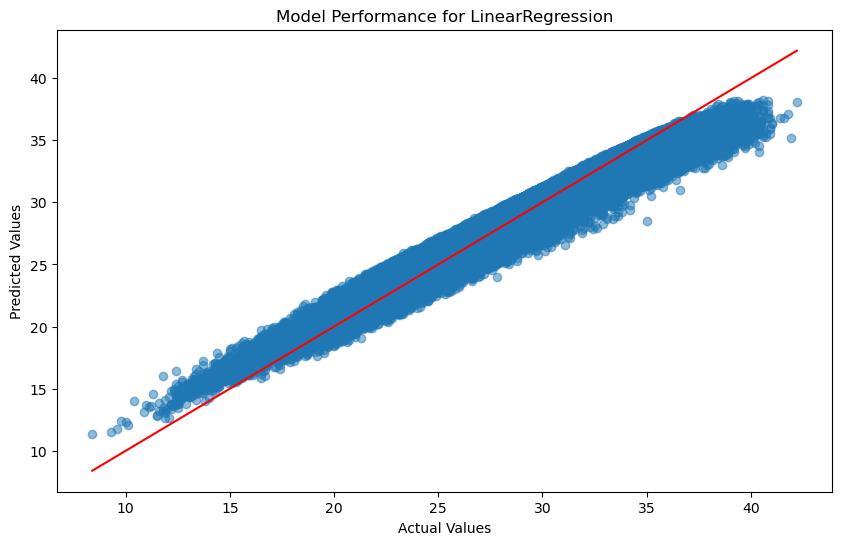

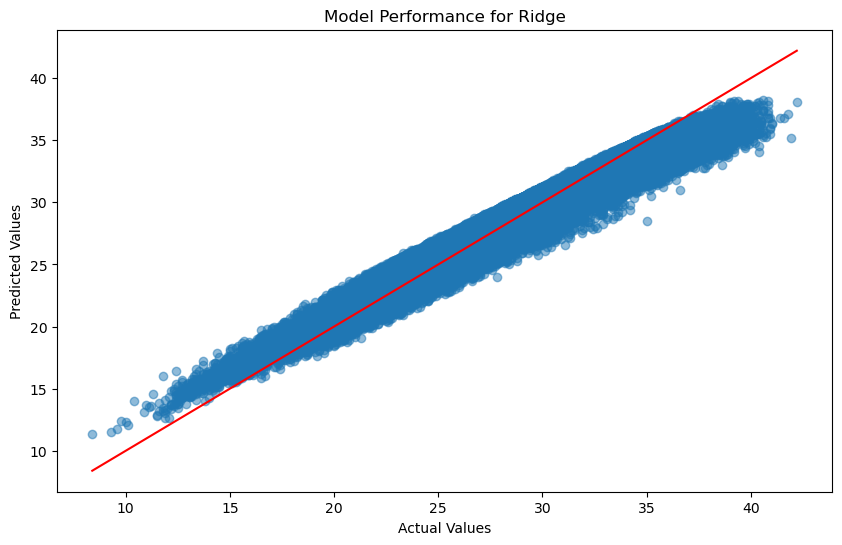

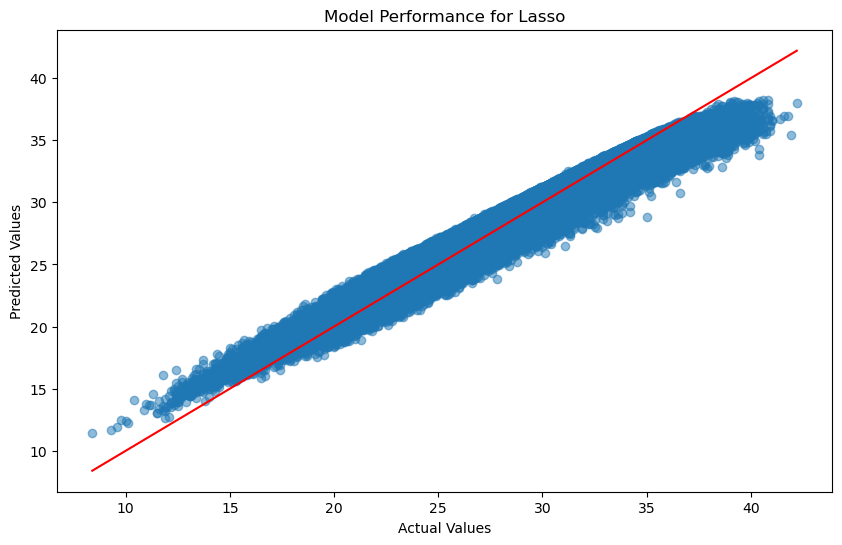

In [28]:
# Evaluate Linear Regression
Nor_linear_mse, Nor_linear_mae, Nor_linear_r2 = train_and_evaluate_normalized(Nor_linear_model, X_train_1, X_test_1, y_train, y_test)

# Evaluate Ridge Regression
Nor_ridge_mse, Nor_ridge_mae, Nor_ridge_r2 = train_and_evaluate_normalized(Nor_ridge_model, X_train_1, X_test_1, y_train, y_test)

# Evaluate Lasso Regression
Nor_lasso_mse, Nor_lasso_mae, Nor_lasso_r2 = train_and_evaluate_normalized(Nor_lasso_model, X_train_1, X_test_1, y_train, y_test)

The three scatter plots visualize the performance of the three simple regression models: Linear, Ridge, and Lasso. As we can see above, these three plots were almost identical visually.

In [29]:
print("Normalized Linear Regression - MSE:", Nor_linear_mse, "MAE:", Nor_linear_mae, "R2:", Nor_linear_r2)
print("Normalized Ridge Regression - MSE:", Nor_ridge_mse, "MAE:", Nor_ridge_mae, "R2:", Nor_ridge_r2)
print("Normalized Lasso Regression - MSE:", Nor_lasso_mse, "MAE:", Nor_lasso_mae, "R2:", Nor_lasso_r2)

Normalized Linear Regression - MSE: 0.36824203248965837 MAE: 0.44359949990261793 R2: 0.9724547732483716
Normalized Ridge Regression - MSE: 0.3682396357306447 MAE: 0.44360120025013755 R2: 0.9724549525306498
Normalized Lasso Regression - MSE: 0.3696850599346754 MAE: 0.447974702813549 R2: 0.9723468319633611


In [30]:
print("Linear Regression - MSE:", linear_mse, "MAE:", linear_mae, "R2:", linear_r2)
print("Ridge Regression - MSE:", ridge_mse, "MAE:", ridge_mae, "R2:", ridge_r2)
print("Lasso Regression - MSE:", lasso_mse, "MAE:", lasso_mae, "R2:", lasso_r2)

Linear Regression - MSE: 0.3682420324896598 MAE: 0.44359949990261643 R2: 0.9724547732483715
Ridge Regression - MSE: 0.3682420339096925 MAE: 0.44359941681810955 R2: 0.9724547731421503
Lasso Regression - MSE: 0.3682288466543767 MAE: 0.44358784558378994 R2: 0.9724557595747295


The values of MSE, MAE, and R2 were almost identical between the original model and the normalized model for the three simpler regression models. This suggests that normalization of the input data does not significantly affect the performance of these regression models for this particular dataset.

Lasso regression, which stands for Least Absolute Shrinkage and Selection Operator, can be particularly useful when we have a large number of features. It has the capability to perform feature selection as part of its function. Given that all three values (MSE, MAE, and R-squared) across the three different regression models (Linear, Ridge, and Lasso) are almost the same, this indicates that for this particular dataset, all three models perform similarly in terms of prediction error and explained variance. Considering Lasso's ability to handle datasets with many features effectively, we select it as the best simpler regression model to compare performance with more complex models.

In the presentation, it was mentioned that prevHrMinTemp could be contributing to low MSE for our models, which is logical as the current temperature would be highly correlated to the previous hour's minimum temperature. Thus, we would drop this column and see how the models above perform. Due to the high correlation of this variable with airTemp, this might have resulted in a substantial increase in MAE value, MSE value, as well as decreased R-squared.

In [33]:
X_train_2 = X_train_1.drop(['prevHrMinTemp'],inplace=False, axis=1)
X_test_2 = X_test_1.drop(['prevHrMinTemp'],inplace=False, axis=1)

# Initialize a linear regression model
linear_model = LinearRegression()

# Initialize a ridge regression model
ridge_model = Ridge(alpha = 10.0, random_state = 141)  

# Initialize a lasso regression model
lasso_model = Lasso(alpha = 0.001, random_state = 141)    

linear_mse, linear_mae, linear_r2 = train_and_evaluate(linear_model, X_train_2, X_test_2, y_train, y_test)

# Evaluate Ridge Regression
ridge_mse, ridge_mae, ridge_r2 = train_and_evaluate(ridge_model, X_train_2, X_test_2, y_train, y_test)

# Evaluate Lasso Regression
lasso_mse, lasso_mae, lasso_r2 = train_and_evaluate(lasso_model, X_train_2, X_test_2, y_train, y_test)

In [34]:
print("Linear Regression - MSE:", linear_mse, "MAE:", linear_mae, "R2:", linear_r2)
print("Ridge Regression - MSE:", ridge_mse, "MAE:", ridge_mae, "R2:", ridge_r2)
print("Lasso Regression - MSE:", lasso_mse, "MAE:", lasso_mae, "R2:", lasso_r2)

Linear Regression - MSE: 0.893904700129704 MAE: 0.5987465355552872 R2: 0.9331341740296566
Ridge Regression - MSE: 0.8939045098655709 MAE: 0.5987464401466688 R2: 0.9331341882617871
Lasso Regression - MSE: 0.8938712652043667 MAE: 0.598669422511917 R2: 0.933136675027692


We will now attempt to fit a simple bagging model to the data and see how well it performs with the test dataset. We generate 100 trees to fit the data by using the default value of the n_estimator parameter. For now, training the bagging model consumes too much time, as it was running for 30 minutes without any output. Thus, given the size of the dataset, the bagging model may not be suitable


In [1]:
# Code is commented out as the bagging model is too computationally intensive

# bagging_weather = RF(max_features=X_train.shape[1], random_state=0)
# bagging_weather.fit(X_train, y_train)

# bagging_y_pred = bagging_weather.predict(X_test)
# np.mean((y_test - bagging_y_pred)**2)

We will now attempt to fit a simple Random Forrest model to the data and see how well it performs with the test dataset. Similar to bagging, we will generate 100 trees to fit the model, but will limit the number of features to be taken into account to be 6. 


In [ ]:
RF_weather = RF(max_features=6,
               random_state=0).fit(X_train, y_train)
y_hat_RF = RF_weather.predict(X_test)

In [30]:
print(np.mean((y_test - y_hat_RF)**2))
print(np.mean(np.abs(y_test - y_hat_RF)))

0.03643217300158907
0.10974133908689959


Similar to the previous parametric models, it was mentioned that prevHrMinTemp could be contributing to low MSE for our models, which is logical as the current temperature would be highly correlated to the previous hour's minimum temperature. Thus, we would drop this column and see how the random forest model performs. Interestingly, the model performs better without the predictor variable prevHrMinTemp.

In [12]:
X_train_without_prevHrMinTemp = X_train.drop(['prevHrMinTemp'],inplace=False, axis=1)
X_test_without_prevHrMinTemp = X_test.drop(['prevHrMinTemp'],inplace=False, axis=1)

RF_weather_2 = RF(max_features=6,
               random_state=0).fit(X_train_without_prevHrMinTemp, y_train)
y_hat_RF_2 = RF_weather_2.predict(X_test_without_prevHrMinTemp)

In [13]:
print(np.mean((y_test - y_hat_RF_2)**2))
print(np.mean(np.abs(y_test - y_hat_RF_2)))

0.019229417797017794
0.08768097418437215
